In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rc
from scipy.signal import find_peaks 
from cProfile import label

In [2]:
hbar = 1.05457*10**(-34) # J*s
c = 2.998*10**8 # m/s
u_to_kg = 1.6605*10**(-27)
pm_to_m = 10**(-12)
kT = 207

In [3]:
# 1a) The bond lengths of the molecules H2, O2, HF, HCl, N2 and NO are:
r_list = [74.1, 120.8, 91.7, 127.5, 109.0, 116.9] #pm
# Calculate the rotational constants in wavenumbers

In [4]:
def rotational_constant(m1, m2, r):
    mu = ((m1*m2)/(m1+m2))*u_to_kg
    # print(mu)
    I = mu*(r*pm_to_m)**2
    # print(I)
    B = (hbar/(4*(np.pi)*c*I))*10**(-2)
    return B

In [5]:
m_list = [1, 16, 19, 35, 14, 2] #atomic units

B_H2 = rotational_constant(m_list[0], m_list[0], r_list[0]) 
B_O2 = rotational_constant(m_list[1], m_list[1], r_list[1])
B_HF= rotational_constant(m_list[0], m_list[2], r_list[2]) 
B_HCl = rotational_constant(m_list[0], m_list[3], r_list[3])
B_N2 = rotational_constant(m_list[4], m_list[4], r_list[4]) 
B_NO = rotational_constant(m_list[4], m_list[1], r_list[5])

print('H2: ', B_H2)
print('O2: ', B_O2) 
print('HF: ', B_HF)
print('HCl: ', B_HCl) 
print('N2: ', B_N2) 
print('NO: ', B_NO)

H2:  61.402862791503566
O2:  1.4440132707490545
HF:  21.102444339403437
HCl:  10.666185365709243
N2:  2.0269545194861887
NO:  1.6521111191259992


In [ ]:
# 1b) Determine the population (relative to J=0) of J=1,2,3,4,5 for both HCl and DCl at room temperature

In [6]:
def boltzmann_dist(m1, m2, r, J, n):
    B = rotational_constant(m1, m2, r)
    Energy_diff = B*n*(2*J+1+n)
    population = (2*(J+n)+1)/(2*J+1)*np.exp(-Energy_diff/(kT))
    return population

In [7]:
J = 0
n = np.array([1,2,3,4,5])

population_HCl = boltzmann_dist(m_list[0], m_list[3], r_list[3], J, n)
print('Popuation HCl: ', population_HCl)

population_DCl = boltzmann_dist(m_list[5], m_list[3], r_list[3], J, n)
print('Popuation DCl: ', population_DCl)

Popuation HCl:  [2.70623226 3.67029896 3.77190645 3.21129816 2.344498  ]
Popuation DCl:  [2.84525731 4.26550918 5.09447921 5.29962857 4.97046557]


In [ ]:
# 2) The rotational-vibrational (stick) spectrum of H79Br and H81Br, is shown in the figure with a zoom in of the central
#    part. Can you tell the abundance of the two isotopologues? Estimate the bond length of HBr based on the spectrum.

# The peaks has approximately the same height, which means the abundance is approximately 50/50

In [8]:
def bond_length(m1, m2, B):
    mu = ((m1*m2)/(m1+m2))*u_to_kg
    I = (hbar/(4*np.pi*c*B))*10**(-2)
    r = (np.sqrt(I/mu))*10**10
    return r

In [9]:
m_Br = [79, 81]
B_HBr = 32.32/4

r_H79Br = bond_length(m_list[0], m_Br[0], B_HBr)
r_H81Br = bond_length(m_list[0], m_Br[1], B_HBr)

print(r_H79Br, r_H81Br)

1.453527616066979 1.4533032889391573


In [ ]:
# 3a) Plot the fundamental transition, including rotational fine structure (up to J = 20) of HCl (˜ν ≈ 2865 cm−1) and
#     DCl in the same infrared spectrum (normalized intensity vs. wavenumbers) at room temperature. The individual
#     rotational-vibrational lines should be represented with sticks. Explain the calculated spectrum.

In [10]:
def intensities(m1, m2, r, n_list, nu):
    B = rotational_constant(m1, m2, r)

    DeltaE_R = []
    DeltaE_P = []
    R_branch = []
    P_branch = []
    pop_list = []
    
    for n in n_list:
        if (n % 2) == 0:
            DeltaE_R.append(nu + n*B)
            DeltaE_P.append(nu - n*B)
            
            J = n/2
            pop = np.exp(-(B*J*(J+1)/kT))*(2*J+1)
            pop_list.append(pop)
            R_branch.append(((J+1)/(2*J+1))*pop)
            P_branch.append((J/(2*J+1))*pop)
        
        else:
            DeltaE_R.append(nu + n*B)
            DeltaE_P.append(nu - n*B)

            R_branch.append(0)
            P_branch.append(0)

    branch = np.hstack((np.array(R_branch)/np.sum(pop_list), np.array(P_branch)/np.sum(pop_list)))
    DeltaE = np.hstack((DeltaE_R, DeltaE_P))
    int = pd.DataFrame(np.array([branch]).T, index = DeltaE, columns = ['intensity'])
    return int

In [11]:
n_array = list(range(1,43))

nu_HCl = 2865
nu_DCl = 2090

int_HCl = intensities(m_list[0], m_list[3], r_list[3], n_array, nu_HCl)
int_DCl = intensities(m_list[5], m_list[3], r_list[3], n_array, nu_DCl)
# display(int_HCl)

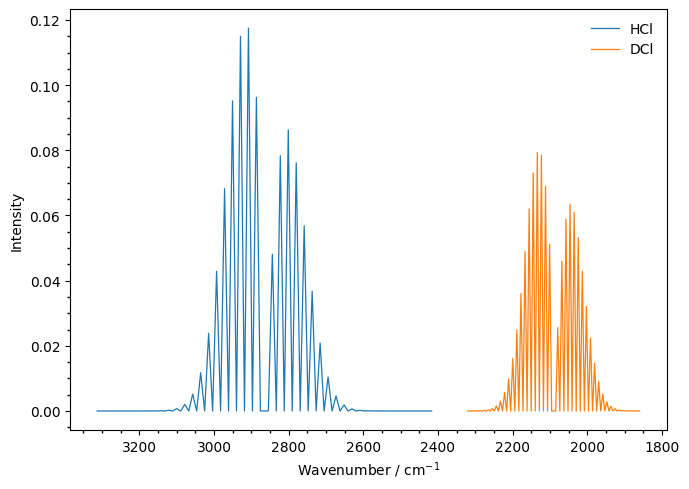

In [12]:
plt.figure(figsize=(7,5))

ax = sns.lineplot(int_HCl, x = int_HCl.index, y = 'intensity', label = 'HCl', color = 'tab:blue', linewidth = 0.9)
sns.lineplot(int_DCl, x = int_DCl.index, y = 'intensity', label = 'DCl', color = 'tab:orange', linewidth = 0.9)
ax.set_ylabel('Intensity')
ax.set_xlabel(r'Wavenumber / cm$^{-1}$')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

plt.legend(frameon = False)

ax.invert_xaxis()

plt.tight_layout()
plt.savefig('problem_3a.png', dpi=150)
plt.show()

In [ ]:
# 3b) Convolute your calculated sticks with Lorentzian or Gaussian or Voigt profiles. What happens when the width
#     of the individual rotational-vibrational transitions increases?

# When the width of the individual transitions is to large, the structure disapears

In [13]:
def gauss(a, x, mu, sigma):
    g = a*np.exp(-0.5*(x-mu)**2/sigma**2)
    return g

sigma = 2
x_HCl = np.arange(2400, 3300, 1)
y_HCl = np.zeros_like(x_HCl, dtype = np.float64)
x_DCl = np.arange(1800, 2300, 1)
y_DCl = np.zeros_like(x_DCl, dtype = np.float64)

for (wavenumber, int) in zip(int_HCl.index.values, int_HCl['intensity']):
    y_HCl += gauss(int, x_HCl, wavenumber, sigma)

for (wavenumber, int) in zip(int_DCl.index.values, int_DCl['intensity']):
    y_DCl += gauss(int, x_DCl, wavenumber, sigma)

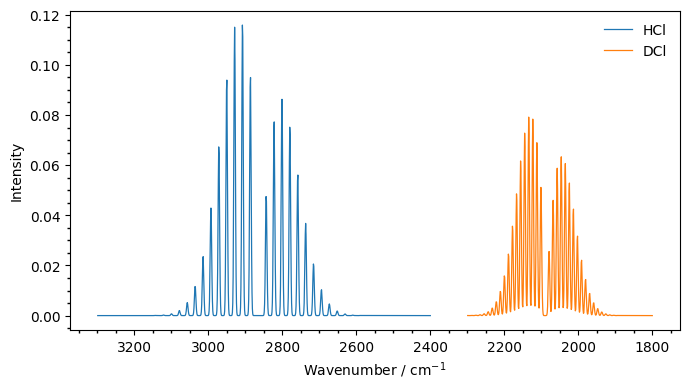

In [15]:
plt.figure(figsize=(7,4))

ax = sns.lineplot(x = x_HCl, y = y_HCl, linewidth = 0.9, color = 'tab:blue', label = 'HCl')
sns.lineplot(x = x_DCl, y = y_DCl, linewidth = 0.9, color = 'tab:orange', label = 'DCl')

ax.set_ylabel('Intensity')
ax.set_xlabel(r'Wavenumber / cm$^{-1}$')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

plt.legend(frameon = False)

ax.invert_xaxis()

plt.tight_layout()
plt.savefig('problem_3b.png', dpi=150)
plt.show()